# Discrete hedging experiment for a European Call option under the Heston model

> TODO: Add a description to the experiment

> Under the Heston but we are using the Black-Scholes delta for hedging

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd

from jax import vmap, grad, jit
import jax.numpy as jnp
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','no-latex'])

from jaxfin.models.heston import UnivHestonModel
from jaxfin.price_engine.black_scholes import european_price, delta_european
from jaxfin.price_engine.fft import fourier_inv_call, delta_call_fourier

from src.experimental.bs_iv import IV_brent
import py_vollib_vectorized

In [3]:
seed = 42

$$
S(0) = 100 \\
\sigma = 0.2 \\
\mu = 0.00 \\
$$

Let set $N = 252$, which means that we are rebalancing our portfolio daily.

In [4]:
# Initialize the Univariate Heston Model
s0 = 100.0
v0 = 0.04
mean = 0.0
kappa = 1.0
theta = 0.04
sigma = 0.1
rho = -0.7

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)

In [5]:
maturity = 1.0
N = 252
dt = maturity / N
n_sim = 100

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

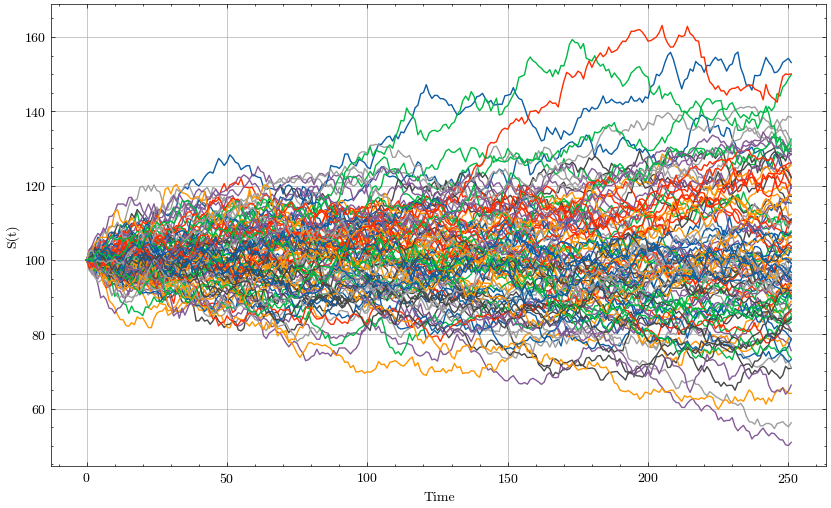

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(stock_paths[:, :100])
plt.ylabel('S(t)')
plt.xlabel('Time')
plt.grid()
plt.show()

In [7]:
discount_rate = 0.0
dividends = 0.0

## Hedging experiment without transaction costs

In [8]:
ticksize = 0.00
K = 100
maturity = 1.0
N = 252
n_sim = 100

v_fourier_delta_call = vmap(delta_call_fourier, in_axes=(0, None, None, None, None, None, None, None, None))
v_v_fourier_delta_call = vmap(v_fourier_delta_call, in_axes=(None, None, None, 0, None, None, None, None, None))
v_fourier_inv_call = vmap(fourier_inv_call, in_axes=(0, None, None, None, None, None, None, None, None))
v_v_fourier_inv_call = vmap(v_fourier_inv_call, in_axes=(None, None, None, 0, None, None, None, None, None))

In [9]:
def heston_vega(s0, K, T, v, mu, theta, sigma, kappa, rho):
    return grad(fourier_inv_call, argnums=3)(s0, K, T, v, mu, theta, sigma, kappa, rho)

_v_heston_vega = vmap(heston_vega, in_axes=(0, None, None, None, None, None, None, None, None))
v_heston_vega = vmap(_v_heston_vega, in_axes=(None, None, None, 0, None, None, None, None, None))

In [10]:
def get_heston_deltas(stock_paths, var_process, K, T, mu, theta, sigma, kappa, rho, N):
    dt = maturity / N
    deltas = [v_v_fourier_delta_call(stock_paths[0], K, T, var_process[0], mu, theta, sigma, kappa, rho).diagonal()]
    deltas_ = [v_v_fourier_delta_call(
        stock_paths[i], 
        K, 
        T - i * dt, 
        var_process[i - 1], 
        mu, 
        theta, 
        sigma, 
        kappa, 
        rho).diagonal() for i in range(1, N)]
    return jnp.asarray(deltas + deltas_)

def get_heston_vegas(stock_paths, var_process, K, T, mu, theta, sigma, kappa, rho, N):
    dt = maturity / N
    vegas = [v_heston_vega(stock_paths[0], K, T, var_process[0], mu, theta, sigma, kappa, rho).diagonal()]
    vegas_ = [v_heston_vega(
        stock_paths[i], 
        K, 
        T - i * dt, 
        var_process[i - 1], 
        mu, 
        theta, 
        sigma, 
        kappa, 
        rho).diagonal() for i in range(1, N)]
    return jnp.asarray(vegas + vegas_)

def get_heston_hedging_deltas(stock_paths, var_process, K, T, mu, theta, sigma, kappa, rho, N):
    vegas = get_heston_vegas(stock_paths, var_process, K, T, mu, theta, sigma, kappa, rho, N)
    deltas = get_heston_deltas(stock_paths, var_process, K, T, mu, theta, sigma, kappa, rho, N)

    return deltas + (rho * sigma / stock_paths) * vegas


In [11]:
def get_transaction_costs(ticksize, ddelta):
    return ticksize * (jnp.abs(ddelta) + 0.01 * ddelta**2)

In [12]:
def hedge_experiment_loop(stock_paths, var_process, K, mu, sigma, maturity, N, ticksize=0.00):
    deltas = get_heston_hedging_deltas(stock_paths, var_process, K, maturity, mu, theta, sigma, kappa, rho, N)
    cs = [v_v_fourier_inv_call(stock_paths[i], K, maturity - i * dt, var_process[i], mu, theta, sigma, kappa, rho).diagonal() for i in range(0, N)]
    b = [cs[0] - deltas[0] * stock_paths[0]]
    vs = [cs[0]]

    for i in range(1, N):
        ddelta = deltas[i] - deltas[i - 1] if i != N - 1 else deltas[i]
        transaction_costs = get_transaction_costs(ticksize, ddelta)

        vs.append(deltas[i - 1] * stock_paths[i] + b[i - 1])
        b.append(vs[i] - deltas[i] * stock_paths[i] - transaction_costs)
        
    hedge_error = jnp.asarray(vs) - jnp.maximum(stock_paths - K, 0)

    return jnp.nanmean(hedge_error[-1]), jnp.nanstd(hedge_error[-1]) / jnp.asarray(cs)[0, 0]

### Experiments

In [13]:
results = {
    'Strike': [],
    'Sigma': [],
    'Maturity': [],
    'Rebalancing_freq': [],
    'E_PL_T': [],
    'Std_PL_T': []
}

In [14]:
def update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=0.00):
    mean_hedge_error, std_hedge_error = hedge_experiment_loop(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

    results['Strike'].append(K)
    results['Sigma'].append(sigma)
    results['Maturity'].append(maturity)
    results['Rebalancing_freq'].append(N)
    results['E_PL_T'].append(mean_hedge_error)
    results['Std_PL_T'].append(std_hedge_error)

    print(f'The mean hedge error is: {mean_hedge_error}')
    print(f'The normalized std of the hedge error is: {std_hedge_error}')

    return results

In [15]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.049089465290308
The normalized std of the hedge error is: 0.08433938026428223


Weekly rebalancing $n=52$

In [ ]:
N = 52

stock_paths = heston_model.sample_paths(maturity, N, n_sim)

In [ ]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.1636512279510498
The normalized std of the hedge error is: 0.27263307571411133


#### Different strike prices

$$
S_0 = 100 \quad K = 80 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [16]:
K = 80
sigma = 0.1
maturity = 1.0
N = 252
n_sim = 100

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [17]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -1.70159346453147e-05
The normalized std of the hedge error is: 0.0202512014657259


Weekly rebalancing $n=52$

In [ ]:
N = 52

stock_paths = heston_model.sample_paths(maturity, N, n_sim)

In [ ]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.1636512279510498
The normalized std of the hedge error is: 0.27263307571411133


$$
S_0 = 100 \quad K = 90 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [18]:
K = 90

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [19]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.02493804693222046
The normalized std of the hedge error is: 0.04582333192229271


Weekly rebalancing $n=52$

In [ ]:
N = 52

stock_paths = heston_model.sample_paths(maturity, N, n_sim)

In [ ]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.1636512279510498
The normalized std of the hedge error is: 0.27263307571411133


$$
S_0 = 100 \quad K = 110 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [20]:
K = 110

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [21]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.005865764804184437
The normalized std of the hedge error is: 0.1538059115409851


Weekly rebalancing $n=52$

In [ ]:
N = 52

stock_paths = heston_model.sample_paths(maturity, N, n_sim)

In [ ]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.1636512279510498
The normalized std of the hedge error is: 0.27263307571411133


$$
S_0 = 100 \quad K = 120 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [22]:
K = 120

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [23]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.012154247611761093
The normalized std of the hedge error is: 0.30382564663887024


Weekly rebalancing $n=52$

In [ ]:
N = 52

stock_paths = heston_model.sample_paths(maturity, N, n_sim)

In [ ]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.1636512279510498
The normalized std of the hedge error is: 0.27263307571411133


### Different maturities

$$
S_0 = 100 \quad K = 100 \quad T = 2.0 \quad n = 504
$$

In [26]:
K = 100
sigma = 0.1
N = 504
T = 504

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [27]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 0.02988269366323948
The normalized std of the hedge error is: 0.14182820916175842


Weekly rebalancing $n=104$

In [ ]:
N = 104

stock_paths = heston_model.sample_paths(T, N, n_sim)

In [ ]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 0.1636512279510498
The normalized std of the hedge error is: 0.27263307571411133


$$
S_0 = 100 \quad K = 100 \quad T = 0.5 \quad n = 121
$$

In [ ]:
N = 121
T = 0.5

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [ ]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 0.02988269366323948
The normalized std of the hedge error is: 0.14182820916175842


Weekly rebalancing $n=104$

In [ ]:
N = 26

stock_paths = heston_model.sample_paths(T, N, n_sim)

In [ ]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 0.1636512279510498
The normalized std of the hedge error is: 0.27263307571411133


$$
S_0 = 100 \quad K = 100 \quad T = 0.2 \quad n = 50
$$

In [ ]:
N = 50
T = 0.2

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [ ]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 0.02988269366323948
The normalized std of the hedge error is: 0.14182820916175842


Weekly rebalancing $n=10$

In [ ]:
N = 10

stock_paths = heston_model.sample_paths(T, N, n_sim)

In [ ]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 0.1636512279510498
The normalized std of the hedge error is: 0.27263307571411133


In [30]:
res_df = pd.DataFrame.from_dict(results)
res_df

,Strike,Sigma,Maturity,Rebalancing_freq,E_PL_T,Std_PL_T
0,100,0.1,1.0,252,-0.049089465,0.08433938
1,80,0.1,1.0,252,-1.7015935e-05,0.020251201
2,90,0.1,1.0,252,0.024938047,0.045823332
3,110,0.1,1.0,252,-0.005865765,0.15380591
4,120,0.1,1.0,252,0.012154248,0.30382565
5,100,0.2,1.0,252,-0.068128355,0.18913737
6,100,0.1,1.0,52,0.029882694,0.14182821
7,100,0.1,1.0,121,-0.06752999,0.10502133


In [31]:
res_df.to_csv('./results/heston_delta_zero.csv')

### Hedging experiments with low transcation costs

### Experiments

In [32]:
ticksize = 0.01
K = 100
sigma = 0.1
maturity = 1.0
N = 252
n_sim = 100

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [33]:
results = {
    'Strike': [],
    'Sigma': [],
    'Maturity': [],
    'Rebalancing_freq': [],
    'E_PL_T': [],
    'Std_PL_T': []
}

In [34]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.08528304845094681
The normalized std of the hedge error is: 0.08856955170631409


Weekly rebalancing $n=52$

In [ ]:
N = 52

stock_paths = heston_model.sample_paths(maturity, N, n_sim)

In [ ]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.1636512279510498
The normalized std of the hedge error is: 0.27263307571411133


#### Different strike prices

$$
S_0 = 100 \quad K = 80 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [ ]:
K = 80
sigma = 0.1
maturity = 1.0
N = 252
n_sim = 100

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [ ]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -1.70159346453147e-05
The normalized std of the hedge error is: 0.0202512014657259


Weekly rebalancing $n=52$

In [ ]:
N = 52

stock_paths = heston_model.sample_paths(maturity, N, n_sim)

In [ ]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.1636512279510498
The normalized std of the hedge error is: 0.27263307571411133


$$
S_0 = 100 \quad K = 90 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [ ]:
K = 90

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [ ]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.02493804693222046
The normalized std of the hedge error is: 0.04582333192229271


Weekly rebalancing $n=52$

In [ ]:
N = 52

stock_paths = heston_model.sample_paths(maturity, N, n_sim)

In [ ]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.1636512279510498
The normalized std of the hedge error is: 0.27263307571411133


$$
S_0 = 100 \quad K = 110 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [ ]:
K = 110

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [ ]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.005865764804184437
The normalized std of the hedge error is: 0.1538059115409851


Weekly rebalancing $n=52$

In [ ]:
N = 52

stock_paths = heston_model.sample_paths(maturity, N, n_sim)

In [ ]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.1636512279510498
The normalized std of the hedge error is: 0.27263307571411133


$$
S_0 = 100 \quad K = 120 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [ ]:
K = 120

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [ ]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.012154247611761093
The normalized std of the hedge error is: 0.30382564663887024


Weekly rebalancing $n=52$

In [ ]:
N = 52

stock_paths = heston_model.sample_paths(maturity, N, n_sim)

In [ ]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.1636512279510498
The normalized std of the hedge error is: 0.27263307571411133


### Different maturities

$$
S_0 = 100 \quad K = 100 \quad T = 2.0 \quad n = 504
$$

In [ ]:
K = 100
sigma = 0.1
N = 504
T = 504

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [ ]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 0.02988269366323948
The normalized std of the hedge error is: 0.14182820916175842


Weekly rebalancing $n=104$

In [ ]:
N = 104

stock_paths = heston_model.sample_paths(T, N, n_sim)

In [ ]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 0.1636512279510498
The normalized std of the hedge error is: 0.27263307571411133


$$
S_0 = 100 \quad K = 100 \quad T = 0.5 \quad n = 121
$$

In [ ]:
N = 121
T = 0.5

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [ ]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 0.02988269366323948
The normalized std of the hedge error is: 0.14182820916175842


Weekly rebalancing $n=104$

In [ ]:
N = 26

stock_paths = heston_model.sample_paths(T, N, n_sim)

In [ ]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 0.1636512279510498
The normalized std of the hedge error is: 0.27263307571411133


$$
S_0 = 100 \quad K = 100 \quad T = 0.2 \quad n = 50
$$

In [ ]:
N = 50
T = 0.2

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [ ]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 0.02988269366323948
The normalized std of the hedge error is: 0.14182820916175842


Weekly rebalancing $n=10$

In [ ]:
N = 10

stock_paths = heston_model.sample_paths(T, N, n_sim)

In [ ]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 0.1636512279510498
The normalized std of the hedge error is: 0.27263307571411133


In [ ]:
res_df = pd.DataFrame.from_dict(results)
res_df

,Strike,Sigma,Maturity,Rebalancing_freq,E_PL_T,Std_PL_T
0,100,0.1,1.0,252,-0.049089465,0.08433938
1,80,0.1,1.0,252,-1.7015935e-05,0.020251201
2,90,0.1,1.0,252,0.024938047,0.045823332
3,110,0.1,1.0,252,-0.005865765,0.15380591
4,120,0.1,1.0,252,0.012154248,0.30382565
5,100,0.2,1.0,252,-0.068128355,0.18913737
6,100,0.1,1.0,52,0.029882694,0.14182821
7,100,0.1,1.0,121,-0.06752999,0.10502133


In [ ]:
res_df.to_csv('./results/heston_delta_low.csv')

### Hedging experiments with high transcation costs

### Experiments

In [52]:
ticksize = 0.05
K = 100
sigma = 0.1
maturity = 1.0
N = 252
n_sim = 100

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [53]:
results = {
    'Strike': [],
    'Sigma': [],
    'Maturity': [],
    'Rebalancing_freq': [],
    'E_PL_T': [],
    'Std_PL_T': []
}

In [54]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.2904830873012543
The normalized std of the hedge error is: 0.09606316685676575


Weekly rebalancing $n=52$

In [ ]:
N = 52

stock_paths = heston_model.sample_paths(maturity, N, n_sim)

In [ ]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.1636512279510498
The normalized std of the hedge error is: 0.27263307571411133


#### Different strike prices

$$
S_0 = 100 \quad K = 80 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [ ]:
K = 80
sigma = 0.1
maturity = 1.0
N = 252
n_sim = 100

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [ ]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -1.70159346453147e-05
The normalized std of the hedge error is: 0.0202512014657259


Weekly rebalancing $n=52$

In [ ]:
N = 52

stock_paths = heston_model.sample_paths(maturity, N, n_sim)

In [ ]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.1636512279510498
The normalized std of the hedge error is: 0.27263307571411133


$$
S_0 = 100 \quad K = 90 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [ ]:
K = 90

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [ ]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.02493804693222046
The normalized std of the hedge error is: 0.04582333192229271


Weekly rebalancing $n=52$

In [ ]:
N = 52

stock_paths = heston_model.sample_paths(maturity, N, n_sim)

In [ ]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.1636512279510498
The normalized std of the hedge error is: 0.27263307571411133


$$
S_0 = 100 \quad K = 110 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [ ]:
K = 110

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [ ]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.005865764804184437
The normalized std of the hedge error is: 0.1538059115409851


Weekly rebalancing $n=52$

In [ ]:
N = 52

stock_paths = heston_model.sample_paths(maturity, N, n_sim)

In [ ]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.1636512279510498
The normalized std of the hedge error is: 0.27263307571411133


$$
S_0 = 100 \quad K = 120 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [ ]:
K = 120

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [ ]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.012154247611761093
The normalized std of the hedge error is: 0.30382564663887024


Weekly rebalancing $n=52$

In [ ]:
N = 52

stock_paths = heston_model.sample_paths(maturity, N, n_sim)

In [ ]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.1636512279510498
The normalized std of the hedge error is: 0.27263307571411133


### Different maturities

$$
S_0 = 100 \quad K = 100 \quad T = 2.0 \quad n = 504
$$

In [ ]:
K = 100
sigma = 0.1
N = 504
T = 504

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [ ]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 0.02988269366323948
The normalized std of the hedge error is: 0.14182820916175842


Weekly rebalancing $n=104$

In [ ]:
N = 104

stock_paths = heston_model.sample_paths(T, N, n_sim)

In [ ]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 0.1636512279510498
The normalized std of the hedge error is: 0.27263307571411133


$$
S_0 = 100 \quad K = 100 \quad T = 0.5 \quad n = 121
$$

In [ ]:
N = 121
T = 0.5

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [ ]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 0.02988269366323948
The normalized std of the hedge error is: 0.14182820916175842


Weekly rebalancing $n=104$

In [ ]:
N = 26

stock_paths = heston_model.sample_paths(T, N, n_sim)

In [ ]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 0.1636512279510498
The normalized std of the hedge error is: 0.27263307571411133


$$
S_0 = 100 \quad K = 100 \quad T = 0.2 \quad n = 50
$$

In [ ]:
N = 50
T = 0.2

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [ ]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 0.02988269366323948
The normalized std of the hedge error is: 0.14182820916175842


Weekly rebalancing $n=10$

In [ ]:
N = 10

stock_paths = heston_model.sample_paths(T, N, n_sim)

In [ ]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 0.1636512279510498
The normalized std of the hedge error is: 0.27263307571411133


In [ ]:
res_df = pd.DataFrame.from_dict(results)
res_df

,Strike,Sigma,Maturity,Rebalancing_freq,E_PL_T,Std_PL_T
0,100,0.1,1.0,252,-0.049089465,0.08433938
1,80,0.1,1.0,252,-1.7015935e-05,0.020251201
2,90,0.1,1.0,252,0.024938047,0.045823332
3,110,0.1,1.0,252,-0.005865765,0.15380591
4,120,0.1,1.0,252,0.012154248,0.30382565
5,100,0.2,1.0,252,-0.068128355,0.18913737
6,100,0.1,1.0,52,0.029882694,0.14182821
7,100,0.1,1.0,121,-0.06752999,0.10502133


In [ ]:
res_df.to_csv('./results/heston_delta_high.csv')